# Home Credit Default Risk Prediction

##### Predicting whether an applicant is capable of repaying a loan or not. 

## 1. Setup shared libraries on path

This setup is done to establish the bridge to use custom libraries.

In [1]:
import lib.initShared  # custom library
import os

In [2]:
#Capture working directory
cwd = os.getcwd()

In [3]:
# Initialize environment to load custom libraries from shared path
lib.initShared.initializeSharedLib(cwd)

## 2. Data Ingestion

### 2.1 Create Spark session

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName('HomeCredit').getOrCreate()

### 2.2 Connect to remote cluster

In [6]:
from S3serializer_Lib.S3Serializer import S3Bucket

<b>Connecting to a remote ec2 instance ip:18.212.194.194</b>

In [7]:
s3=S3Bucket()
s3.connect(host = "18.212.194.194", username = "centos", key = 'data/InternalPOC_Digital.pem')

Connecting to host  18.212.194.194
Connected


### 2.3 Fetch data from remote cluster

<b>Saving data into Local system<b>

In [8]:
s3.get_dir_remote(cwd+'/data/dataset','home_credit')

Getting data...
Getting File--> part-00000-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00001-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00002-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00003-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> _SUCCESS
['part-00000-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00001-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00002-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00003-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', '_SUCCESS']


### 2.4 Load data

<b>Loading data into spark for processing</b>

In [9]:
data=spark.read.parquet(cwd+'/data/dataset')

In [ ]:
#data cleaning in one command

## 3. Data Cleansing

###  Data Cleaning library performs the following functions:<br>
1. Removes the column containing highest number (30%) of null values
2. Imputation is first perfromed for categorical columns followed by the numerical ones
3. Imputes the categorical null containing columns with frequent occurring value of the respective column
4. Imputes the categorical null containing columns with the mean of the respective column 
5. The name of imputed features are prefixed with 'imputed_'
6. Returns the final dataframe with reduced columns after performing required deletions and imputations

In [10]:
from Data_Cleaning_Lib.CleanLib import DataCleaningLib

In [11]:
cln = DataCleaningLib()

In [12]:
data=cln.cleaning(data)

1.Data Cleaning and Preprocessing
processing--> SK_ID_CURR
processing--> TARGET
processing--> NAME_CONTRACT_TYPE
processing--> CODE_GENDER
processing--> FLAG_OWN_CAR
processing--> FLAG_OWN_REALTY
processing--> CNT_CHILDREN
processing--> AMT_INCOME_TOTAL
processing--> AMT_CREDIT
processing--> AMT_ANNUITY
processing--> AMT_GOODS_PRICE
processing--> NAME_TYPE_SUITE
processing--> NAME_INCOME_TYPE
processing--> NAME_EDUCATION_TYPE
processing--> NAME_FAMILY_STATUS
processing--> NAME_HOUSING_TYPE
processing--> REGION_POPULATION_RELATIVE
processing--> DAYS_BIRTH
processing--> DAYS_EMPLOYED
processing--> DAYS_REGISTRATION
processing--> DAYS_ID_PUBLISH
processing--> OWN_CAR_AGE
processing--> FLAG_MOBIL
processing--> FLAG_EMP_PHONE
processing--> FLAG_WORK_PHONE
processing--> FLAG_CONT_MOBILE
processing--> FLAG_PHONE
processing--> FLAG_EMAIL
processing--> OCCUPATION_TYPE
processing--> CNT_FAM_MEMBERS
processing--> REGION_RATING_CLIENT
processing--> REGION_RATING_CLIENT_W_CITY
processing--> WEEKDAY

#### Saving the cleaned data so it can be used for later processes without re-doing the previous steps

In [2]:
data.write.parquet(cwd+'data/cleaned.parquet')

### 3.1 Feature Importance
Feature selection algorithms gives us a high level overview of the features that are affecting the statistical model. In other words this gives us relatively the most important features from our dataset.We can use these features for our final model building task without Overfitting(feeding the model with too many features that can inversely affect the model outcome).
<hr>
Our Feature Importance Library supports the following Implementations
<br>
1. LightGBM<br>
2. CatBoostClassifier<br>
3. RandomForestClassifier<br>
<br>
In the following, we are going to use: <br><b>LightGBM</b> for Feature Importance

In [ ]:
#add more

#### Converting cleaned spark data into pandas dataframe for feature selection as lightGBM cannot work on Spark data frame.

In [4]:
data_pandas=data.toPandas()
y=data_pandas['TARGET'].values
data_pandas.drop(['TARGET','SK_ID_CURR'],axis=1,inplace=True)
categorical_columns=set(data_pandas.columns)-set(data_pandas._get_numeric_data().columns)
numeric_columns=data_pandas._get_numeric_data().columns
X=data_pandas[list(numeric_columns)].values

"\ndata_pandas=data.toPandas()\ny=data_pandas['TARGET'].values\ndata_pandas.drop(['TARGET','SK_ID_CURR'],axis=1,inplace=True)\ncategorical_columns=set(data_pandas.columns)-set(data_pandas._get_numeric_data().columns)\nnumeric_columns=data_pandas._get_numeric_data().columns\nX=data_pandas[list(numeric_columns)].values"

In [19]:
from Feature_Importance_Lib.Feature_Importance import Feature_Importance_Transformer
fi = Feature_Importance_Transformer(data_pandas)

#### Why LightGBM
1. lightGBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm
<br>
2. lightGBM supports both categorical and numerical data (unlike random forest which supports only numerical features or chi-sqare which supports only categorical features)
<br>
3. lightGBM is faster than most of the other algorithms(such as Random Forest)

In this library, the threshold value for the number of features to be listed could be specified manually. By default it lists all the features.

Plot Top 40 feature importances…


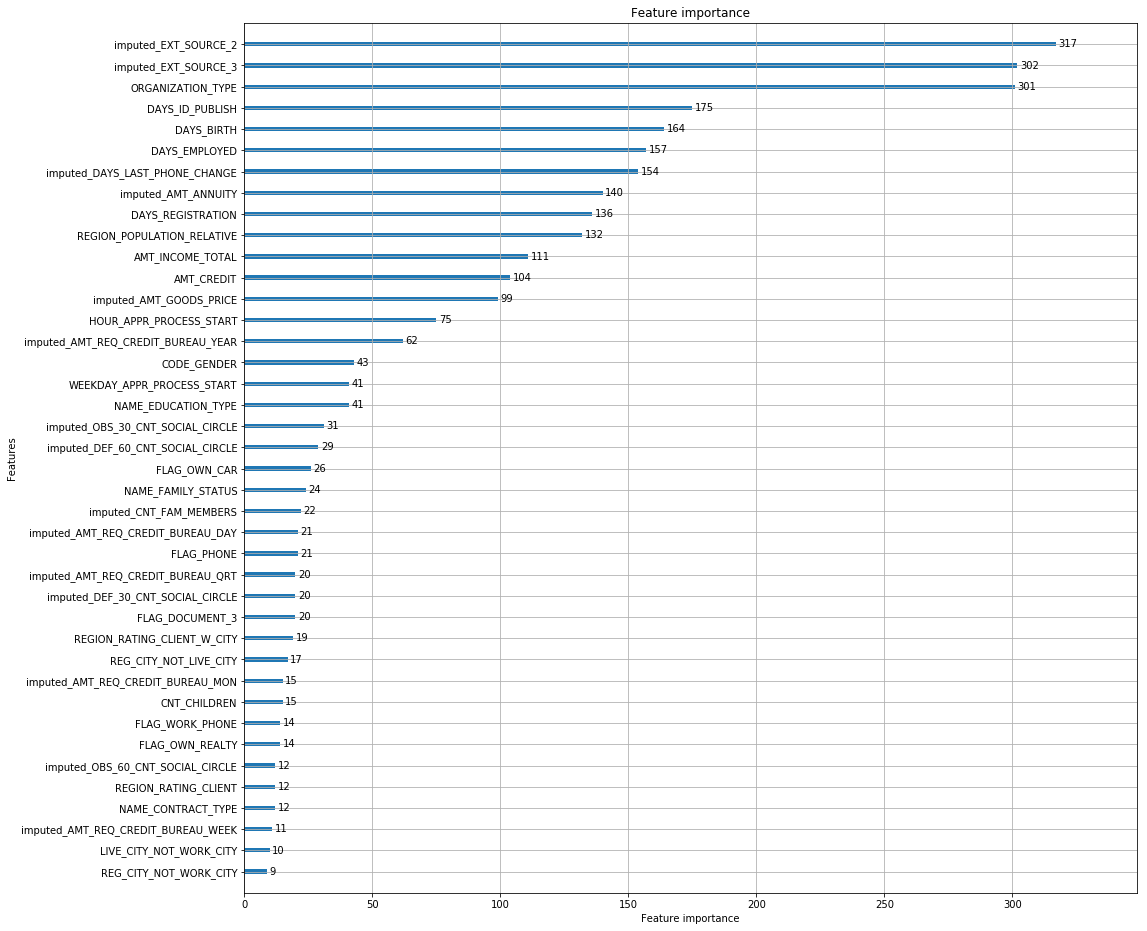

In [20]:
fi.feature_importance_lightGBM(y=y,categorical_columns=categorical_columns,n_features=40)

##### The top 40 features that are of high importance for building the model are listed in order.

### 3.2 Label Encoding


#### Why Label Encoding and  One Hot Encoding?
   Certain algorithms requires numerical values as their predictor variables. Hence Label Encoding or One Hot Encoding becomes necessary. Label Encoding in pyspark is done using StringIndexer class. It gives numerical aliases to different classes
<hr>

#### Our  Label Encoding Library supports the following implementation <br>

1.StringIndexer (spark's native label encoder) needs user to pass in the columns that are to be encoded whereas our library(<b>LabelEncode</b>) takes in only the target/label columns as input.<br>
2.Encodes all the categorical columns in the dataframe and returns the string indexed dataframe.

In [28]:
from Encode_Lib import EncodeLib

In [21]:
pp = EncodeLib.LabelEncode(outputCols=['TARGET'])

In [22]:
data = pp.transform(data)

FLAG_OWN_REALTY
NAME_CONTRACT_TYPE
WEEKDAY_APPR_PROCESS_START
FLAG_OWN_CAR
ORGANIZATION_TYPE
CODE_GENDER
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_TYPE_SUITE
NAME_HOUSING_TYPE


### 3.3 One Hot Encoding

#### Our Label Encoding Library supports the following implementation <br>
1.OHEncode encodes the Label encoded data as well as determines if the above transformation is necessary.<br>
2.It encodes only if the there are more than 2 distinct categories in a column.(i.e.)other than two catgories<br>
3.The resulting output has the binary vectors appended to the end of each row.<br>

In [ ]:
#Why we need OH encoding and what does it mean

In [24]:
ohe = EncodeLib.OHEncode()

In [25]:
data = ohe.transform(data)

### 3.4 Vector Encode
1.VectorAssembler is used to combine raw features and features generated by different feature transformers into a single vector column named 'features'(vector) which can be used for model building.<br>
2.VectorAssembler accepts the following input column types: all numeric types, boolean type, and vector type.


In [26]:
vec = EncodeLib.VectorChange(outputCols=['TARGET'])

In [27]:
data = vec.transform(data)

## 4. Model Building 

Our Model_Fit Library supports the following classification algorithms<br> 
1.Logistic regression<br>
2.Random Forest
<hr>

The output of each model would be the ROC value of the respective model.

In [29]:
from Model_Fit_Lib import Model_Fit

### 4.1 Logistic regression

In [30]:
model1 = Model_Fit.ModelFit(inputCol='LR')

In [31]:
log_reg_pred = model1.transform(data)

In [32]:
model1._evaluate_prediction()

0.7384559798478479


### 4.2 Random Forest

In [33]:
model2 = Model_Fit.ModelFit(inputCol='RF')

In [34]:
rand_forest_pred = model2.transform(data)

In [35]:
model2._evaluate_prediction()

0.7091730705834485


##### From the models applied above, Logistic Regression seems to give the best ROC score of  0.73

### 4.3 Model saving

Model is saved in local directory for any future use

In [37]:
log_reg_pred.save(cwd+'/data/log_reg.pkl')

## 5. Saved model Usage

##### The saved model can be applied on other unseen data.

from pyspark.ml.classification import LogisticRegressionModel

##### The model is loaded to show the usage of saving and loading

In [39]:
mm = LogisticRegressionModel.load(cwd+'/data/log_reg.pkl')

In [40]:
predicted=mm.transform(data)

The prediction column shows the prediction of loan repayment of each user

In [41]:
predicted.select('prediction').show()

+----------+
|prediction|
+----------+
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 20 rows



## 6. API Deployment

In [42]:
import apilib  # shared custom library

In [43]:
swaggerSpecFile = cwd+'/data/swagger_HomeCreditRisk.yaml'
appPort = 8000

In [44]:
# Swagger UI becomes available after running API on URL http://<serverUrl>:mappedPort/ui
# mappedPort is port mapped as per nginx configuration
# For port 8000, mappedPort is 9390, thus URL is http://34.198.60.96:9390/ui/

# Run API
apilib.api_run(swaggerSpecFile, appPort)

# To stop the API, interrupt the cell (using button provided) or shutdown notebook (using Notebook interface)

 * Running on http://0.0.0.0:8000/ (Press CTRL+C to quit)
